In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from IPython.display import display
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
sns.set_style('whitegrid')

In [56]:
mlp_baseline_results = pd.read_csv('simple_mlp_results.csv')
mlp_baseline_results.replace({'simple_mlp_initializer': 'MLP'}, inplace=True)

mlp_xi_reg_results = pd.read_csv('mlp_xi_reg_results.csv')
mlp_xi_reg_results.replace({'mlp_xi_reg_initializer': 'MLP+CRP'}, inplace=True)

mlp_results = pd.concat([mlp_baseline_results, mlp_xi_reg_results])

ftl_baseline_results = pd.read_csv('ftl_mlp_results.csv')
ftl_baseline_results.replace({'ftl_mlp_initializer': 'FTL'}, inplace=True)

ftl_xi_reg_results = pd.read_csv('ftl_mlp_xi_reg_results.csv')
ftl_xi_reg_results.replace({'ftl_mlp_xi_reg_initializer': 'FTL+CRP'}, inplace=True)

ftl_results = pd.concat([ftl_baseline_results, ftl_xi_reg_results])
results = pd.concat([mlp_results, ftl_results])

In [57]:
cols = ['dataset', 'method', 'fitness_rule', 'fitness', 'ACC', 'MCC', 'avg_odds_diff', 'stat_par_diff', 'eq_opp_diff']

In [58]:
results.replace({'adult_dataset_reader': 'Adult Income', 'compas_dataset_reader': 'Compas Recidivism', 'german_dataset_reader': 'German Credit', 'bank_dataset_reader': 'Bank Marketing'}, inplace=True)
results.rename(columns={'avg_odds_diff': 'Equalized Odds', 'stat_par_diff': 'Statistical Parity', 'eq_opp_diff': 'Equal Opportunity', 'MCC': 'Mathew Correlation', 'ACC': 'Accuracy'}, inplace=True)

In [59]:
display(results)

,dataset,method,fitness_rule,fitness,Accuracy,Mathew Correlation,Equalized Odds,Statistical Parity,Equal Opportunity,solution
0,Adult Income,MLP,mcc_parity,0.392537,0.851299,0.585170,0.113127,0.192633,0.142532,{'dropout': 0.16228954240968418}
1,Adult Income,MLP,mcc_odds,0.473935,0.851520,0.585500,0.111565,0.198915,0.132052,{'dropout': 0.1482543145261793}
2,Adult Income,MLP,mcc_opportunity,0.460175,0.851410,0.585064,0.103235,0.191606,0.124889,{'dropout': 0.17861515209545933}
3,Adult Income,MLP,acc_parity,0.661796,0.844887,0.565373,0.082386,0.183090,0.084174,{'dropout': 0.15655371267306142}
4,Adult Income,MLP,acc_odds,0.766170,0.850857,0.577932,0.084687,0.180366,0.093891,{'dropout': 0.1698638434734938}
...,...,...,...,...,...,...,...,...,...,...
355,German Credit,FTL+CRP,mcc_odds,0.185944,0.705000,0.288309,0.102366,0.139706,0.094841,"{'l2': 0.01, 'dropout': 0.10106500911682068, '..."
356,German Credit,FTL+CRP,mcc_opportunity,0.348196,0.765000,0.404544,0.166332,0.112130,0.056348,"{'l2': 0.01, 'dropout': 0.055735168573605956, ..."
357,German Credit,FTL+CRP,acc_parity,0.689560,0.750000,0.367562,0.071392,0.060440,0.042784,"{'l2': 0.01, 'dropout': 0.13197189864137626, '..."
358,German Credit,FTL+CRP,acc_odds,0.657200,0.670000,0.089904,0.012800,0.017328,0.023625,"{'l2': 0.001, 'dropout': 0.13429596161992546, ..."


In [60]:
datasets = results['dataset'].unique().tolist()
datasets

['Adult Income', 'Bank Marketing', 'Compas Recidivism', 'German Credit']

In [61]:
fitness_rules = results['fitness_rule'].unique().tolist()
fitness_rules

['mcc_parity',
 'mcc_odds',
 'mcc_opportunity',
 'acc_parity',
 'acc_odds',
 'acc_opportunity']

In [62]:
fitness_rules_target_metrics = {
    'mcc_parity': {'performance': 'Mathew Correlation', 'fairness': 'Statistical Parity'},
    'mcc_opportunity': {'performance': 'Mathew Correlation', 'fairness': 'Equal Opportunity'},
    'mcc_odds': {'performance': 'Mathew Correlation', 'fairness': 'Equalized Odds'},
    'acc_parity': {'performance': 'Accuracy', 'fairness': 'Statistical Parity'},
    'acc_opportunity': {'performance': 'Accuracy', 'fairness': 'Equal Opportunity'},
    'acc_odds': {'performance': 'Accuracy', 'fairness': 'Equalized Odds'}
}

fitness_rules_target_metrics = {
    'mcc_parity': ('Mathew Correlation', 'Statistical Parity'),
    'mcc_opportunity': ('Mathew Correlation', 'Equal Opportunity'),
    'mcc_odds': ('Mathew Correlation', 'Equalized Odds'),
    'acc_parity': ('Accuracy', 'Statistical Parity'),
    'acc_opportunity': ('Accuracy', 'Equal Opportunity'),
    'acc_odds': ('Accuracy', 'Equalized Odds')
}
fitness_rules_abvr = {
    'mcc_parity': 'Max(MCC - Stat. Parity)',
    'mcc_opportunity': 'Max(MCC - Eq. Odds)',
    'mcc_odds': 'Max(MCC - Eq. Opp.)',
    'acc_parity': 'Max(Acc - Stat. Parity)',
    'acc_opportunity': 'Max(Acc - Eq. Odds)',
    'acc_odds': 'Max(Acc - Eq. Opp.)'
}
results['Performance'] = 0
results['Fairness'] = 0
results['Fitness Rule'] = ''
for fitness_rule, (performance_metric, fairness_metric) in fitness_rules_target_metrics.items():
    results.loc[results.fitness_rule == fitness_rule,'Performance'] = results.loc[results.fitness_rule == fitness_rule,performance_metric]
    results.loc[results.fitness_rule == fitness_rule,'Fairness'] = results.loc[results.fitness_rule == fitness_rule,fairness_metric]
    results.loc[results.fitness_rule == fitness_rule,'Fitness Rule Abvr'] = fitness_rules_abvr[fitness_rule]
    results.loc[results.fitness_rule == fitness_rule,'Fitness Rule'] = 'Max(%s - %s)' % fitness_rules_target_metrics[fitness_rule]

/tmp/ipykernel_139227/4238366629.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.58517004 0.58512823 0.5840247  0.5836371  0.57625737 0.5769683
 0.58075151 0.57811729 0.57147862 0.55847176 0.56402881 0.58191431
 0.58343253 0.57740222 0.51579307 0.30958237 0.37962947 0.55899189
 0.53558872 0.2598879  0.57717035 0.50086739 0.33275221 0.37929293
 0.47729109 0.29196869 0.29037704 0.52303609 0.27480633 0.38668781
 0.50626951 0.29960979 0.4042848  0.52119218 0.2936422  0.33522388
 0.49730721 0.25112662 0.35119067 0.510052   0.26843855 0.36081008
 0.52157495 0.30114722 0.42995147 0.48267704 0.29056691 0.23139881
 0.54223416 0.23653437 0.27041017 0.52121263 0.25759348 0.23912165
 0.5223892  0.27406652 0.22303564 0.54094974 0.27699558 0.30939251
 0.51731345 0.30339828 0.37825089 0.52113734 0.26323857 0.33963196
 0.5538225  0.27850228 0.30234984 0.51877126 0.29494101 0.2648939
 0.52742877 0.24492927 0.13407928 0.5353

In [63]:
methods = ['MLP', 'MLP+CRP', 'FTL', 'FTL+CRP']

## Possible names
- Sensitive Correlation Regularization/Penalty
- Redlining Regularization/Penalty
- Senstive-$L_2$ Regularization

Let
- $X \in \mathbb{R}^{n\times d}$ represent a dataset with $n$ instances and $d$ features
- $X_i \in \mathbb{R}^n, \; 1 \leq i \leq d$ be the $i$-th feature of the dataset
- $A = X_i \in \mathbb{R}^n$ the sensitive feature (protected) for some $i$
- $W^{(1)} \in \mathbb{R}^{d \times h}$ the weight matrix for the first hidden layer, with $h$ being the number of neurons in this layer.
- $\lambda \in \mathbb{R}^{d}$ the vector of regularization strengths for each feature
- $\alpha$ a scalar that controls the overall strength of the regularization

### Regularization Term
The regularization term $R(\mathbf{W}^{(1)})$ applied to the weight matrix $\mathbf{W}^{(1)}$ of the first hidden layer is defined as:
$$R(\mathbf{W}^{(1)}) = \sum_{i=1}^d \lambda_i \sum_{j=1}^h (W^{(1)}_{ij})^2$$
Here, $\lambda_i = |correlation(A,X_i)|$ is the regularization strength for the $i$-th input feature using an arbitrary correlation coefficient (eg. Pearson r, Spearman r, Kendall tau, Chatterjee xi) within sensitive feature A, and $W^{(1)}_{ij}$ is the weight connecting the $i$-th input feature to the $j$-th neuron in the first hidden layer.

The total loss function $L$ for the MLP, incorporating sensitive-$L_2$ regularization, is:
$$L = L_0 + \alpha \; R(\mathbf{W}^{(1)})$$
where $L_0$ is the primary loss function of the network




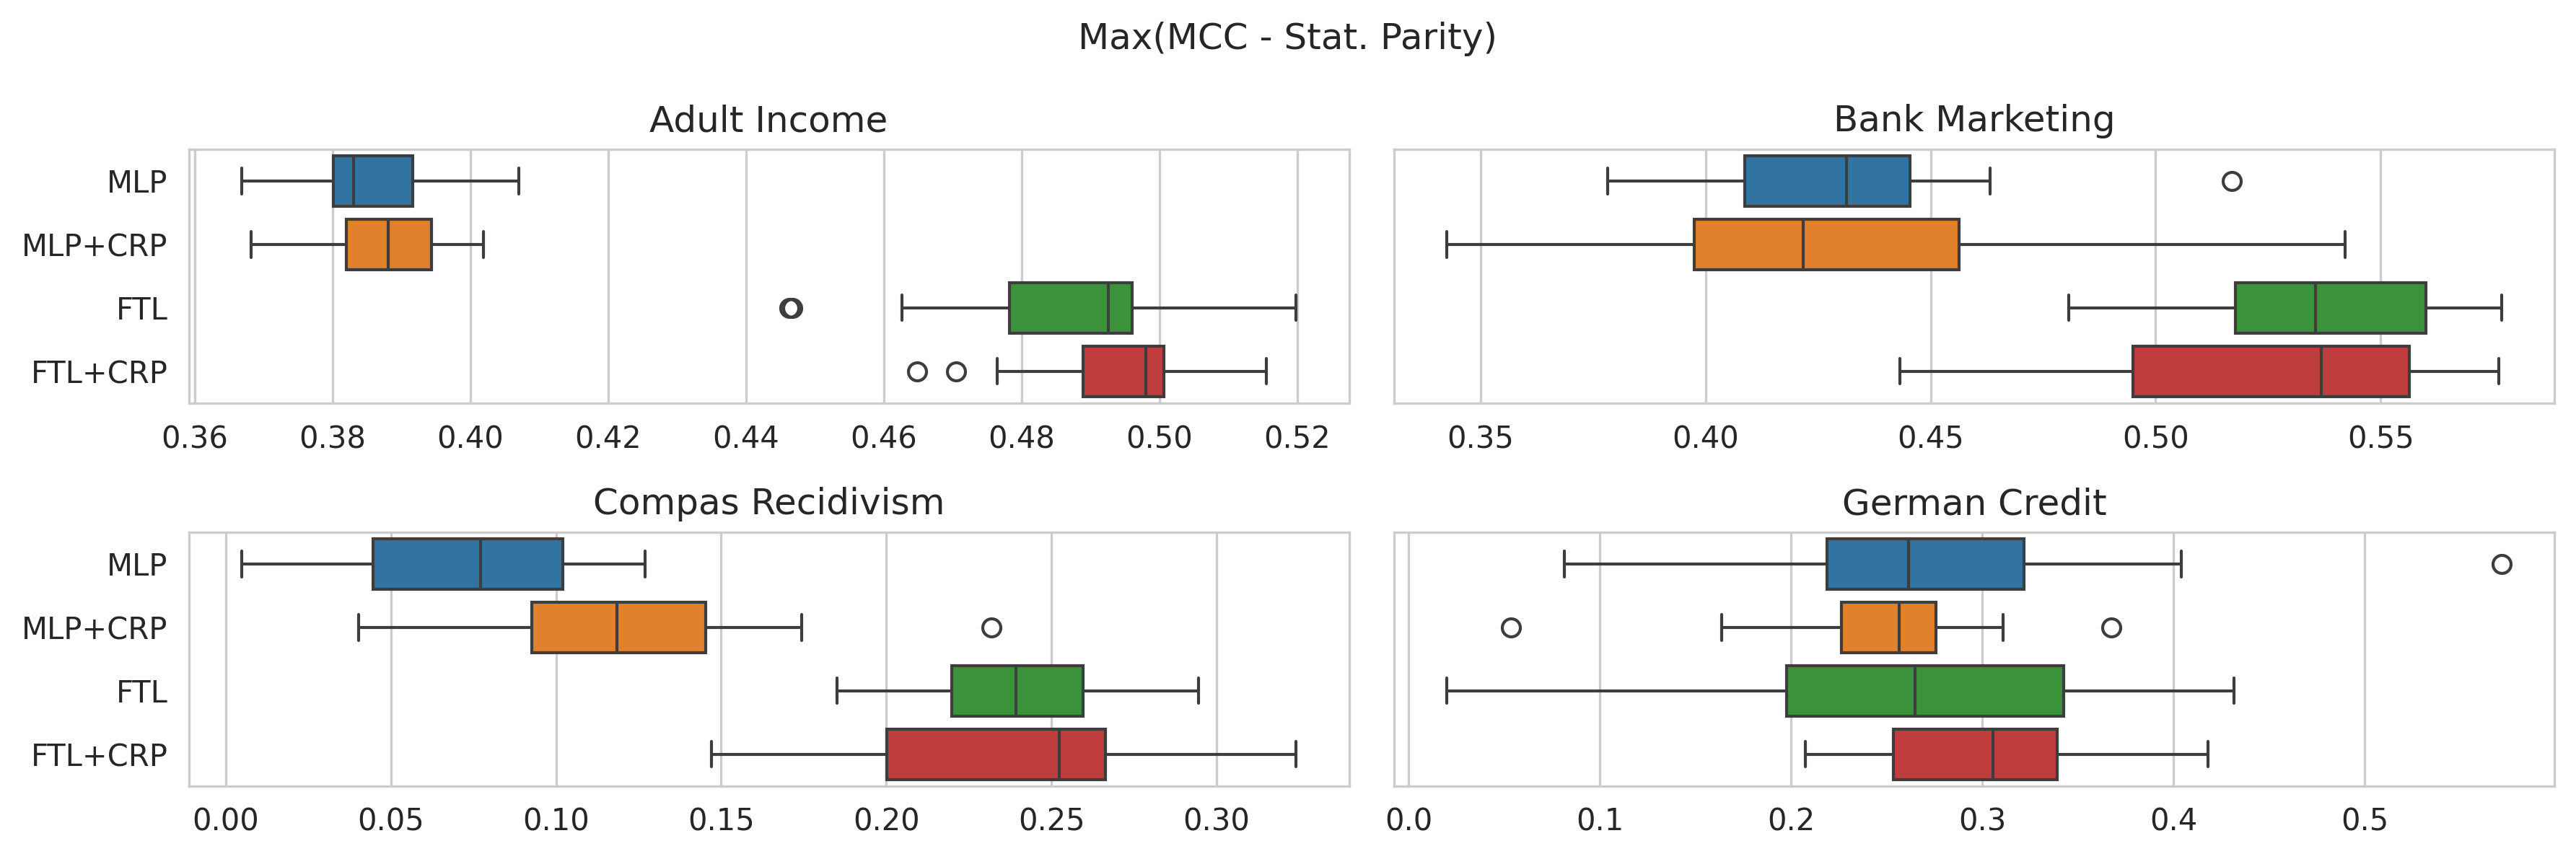

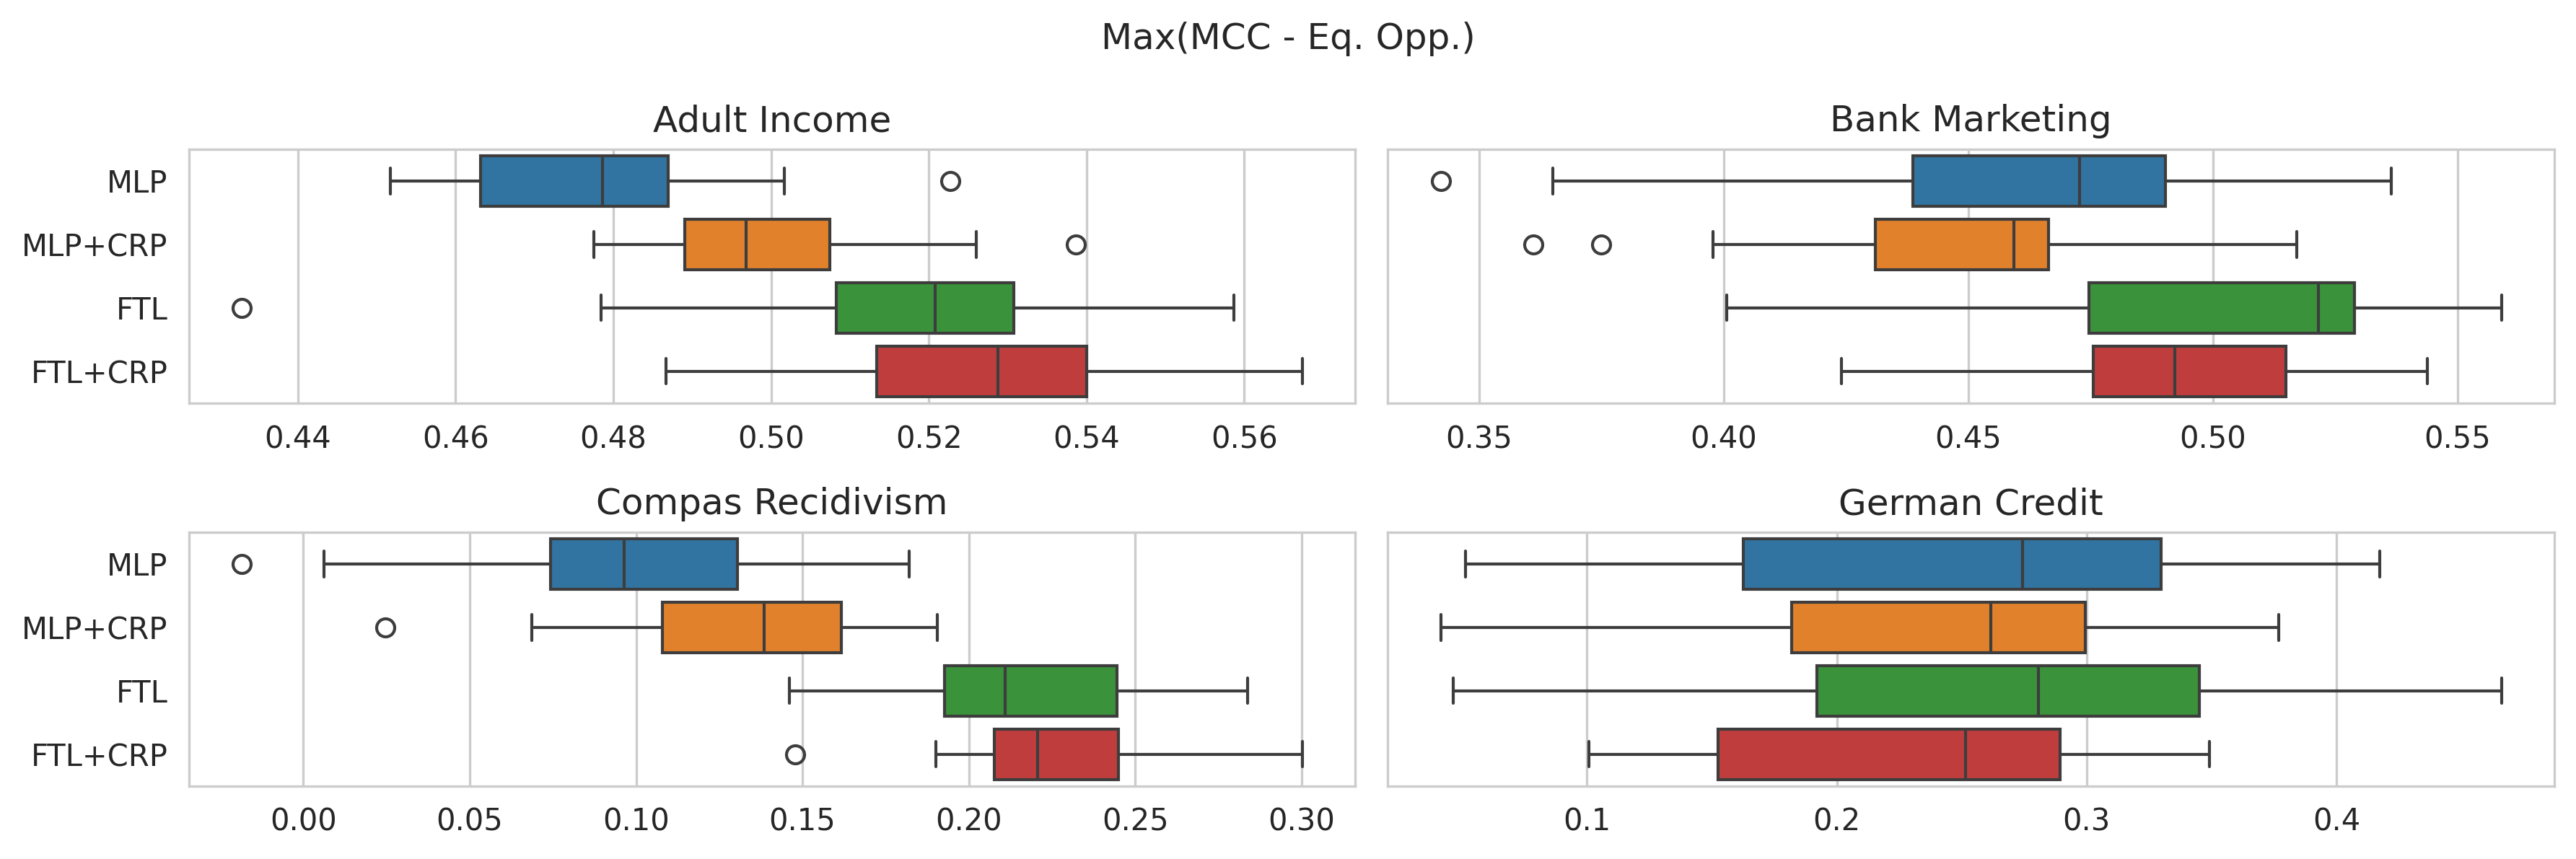

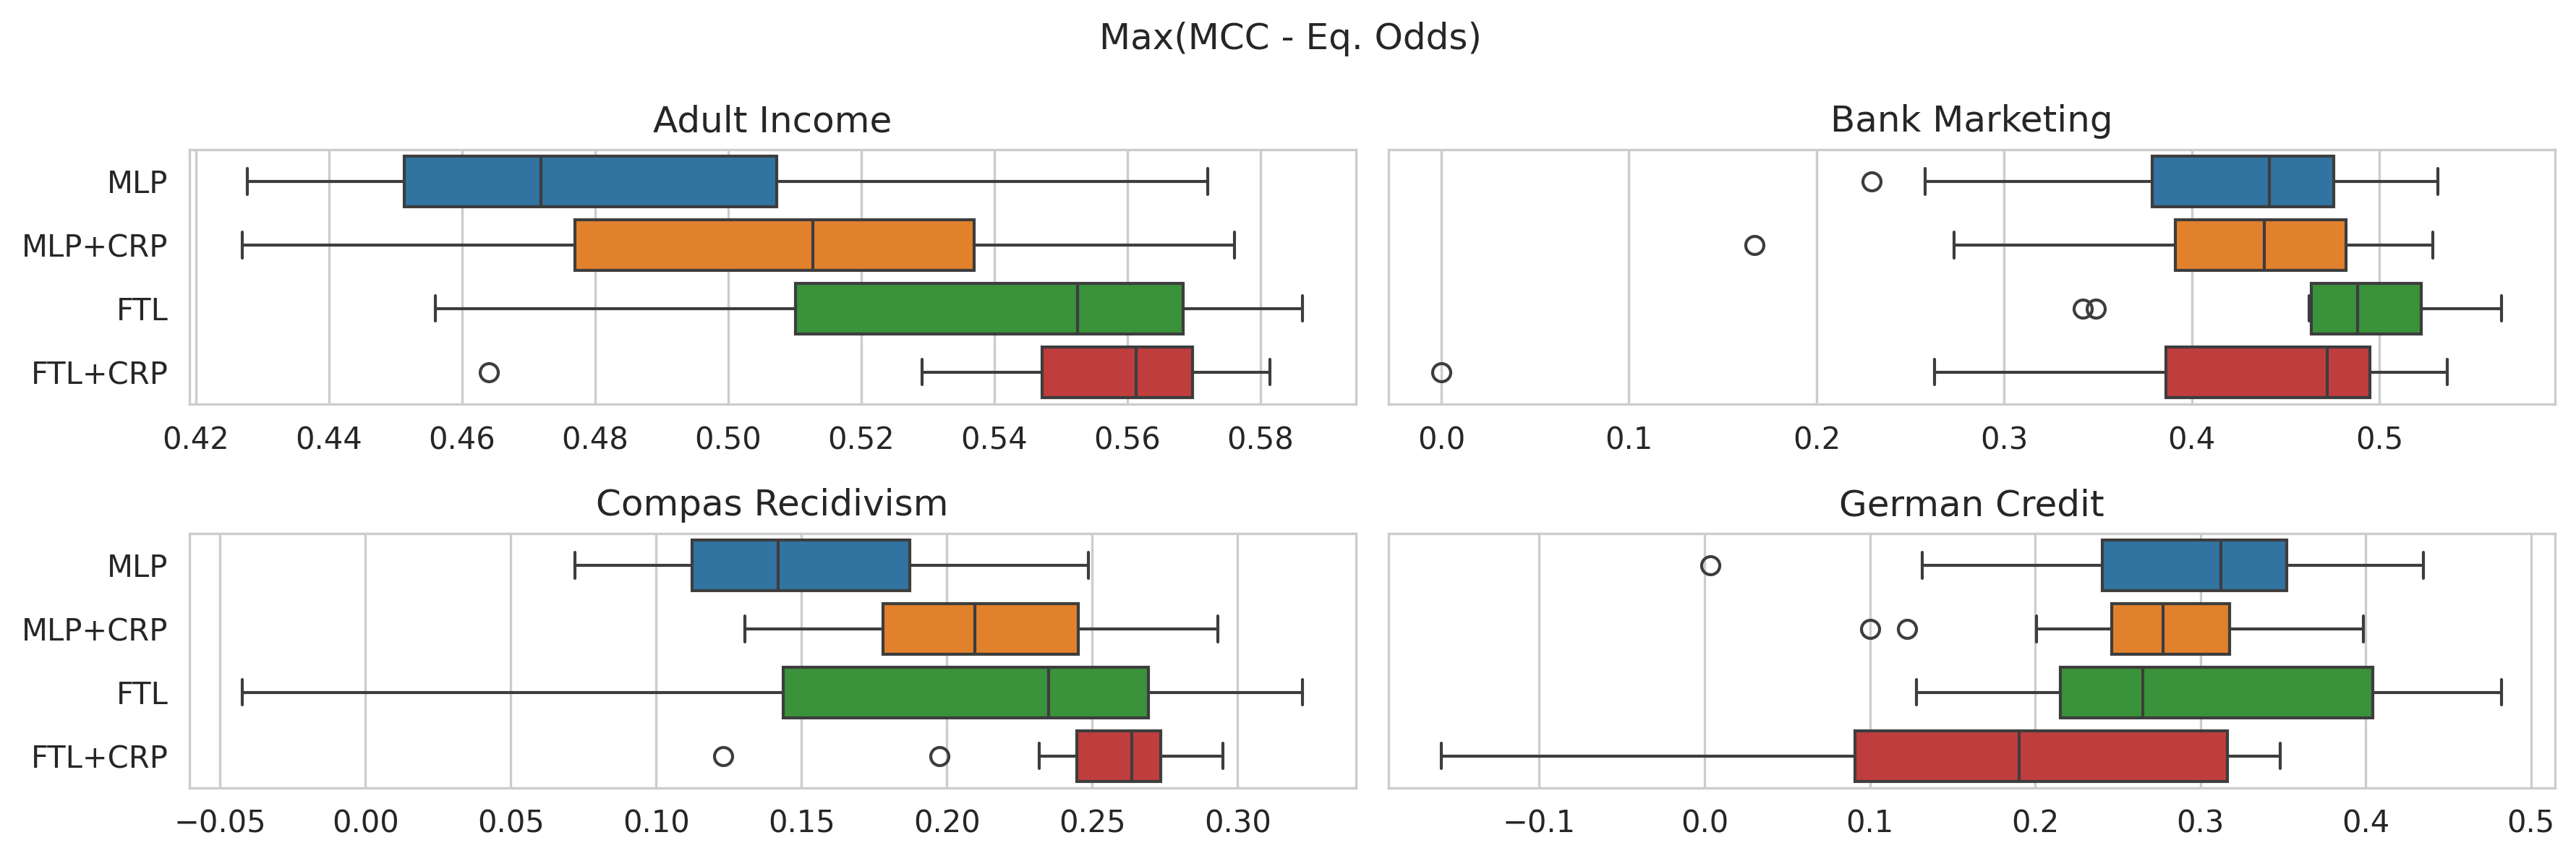

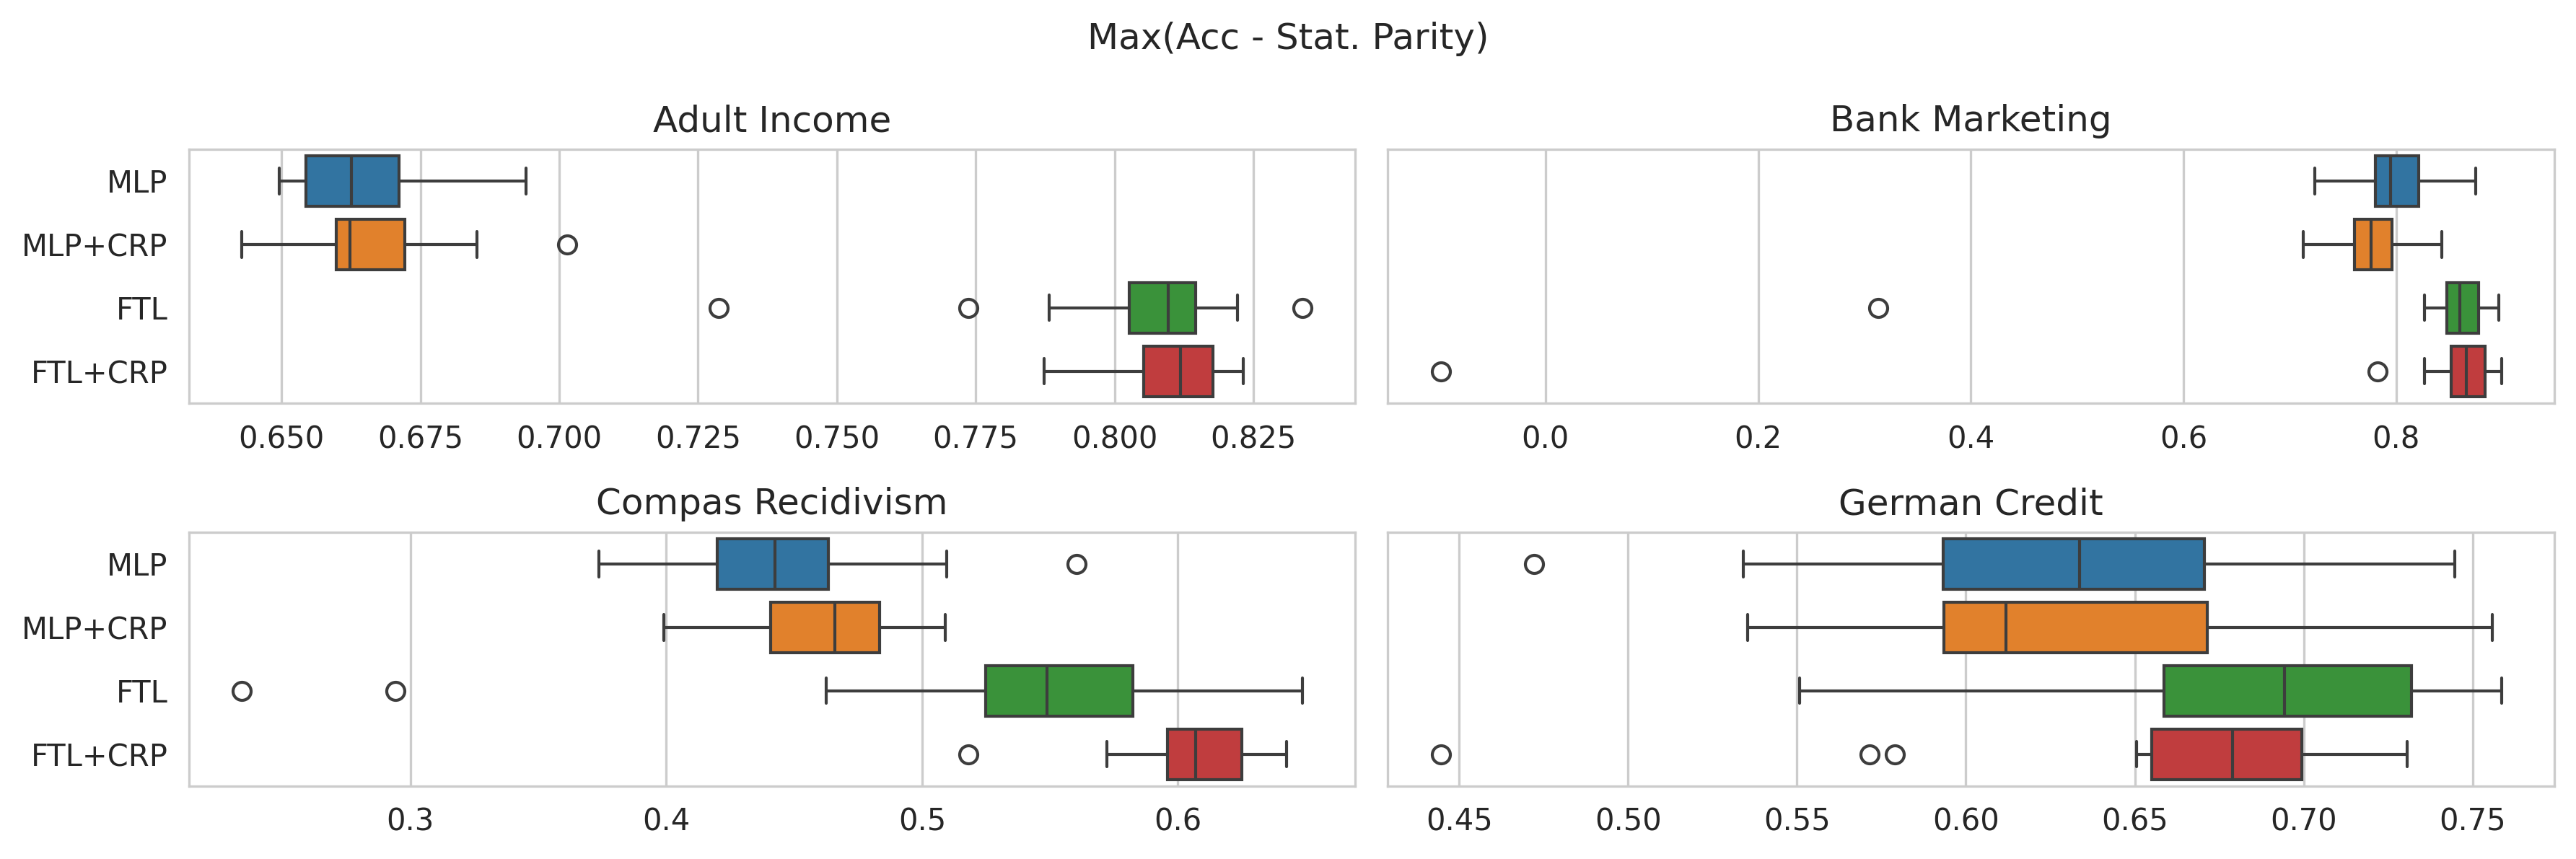

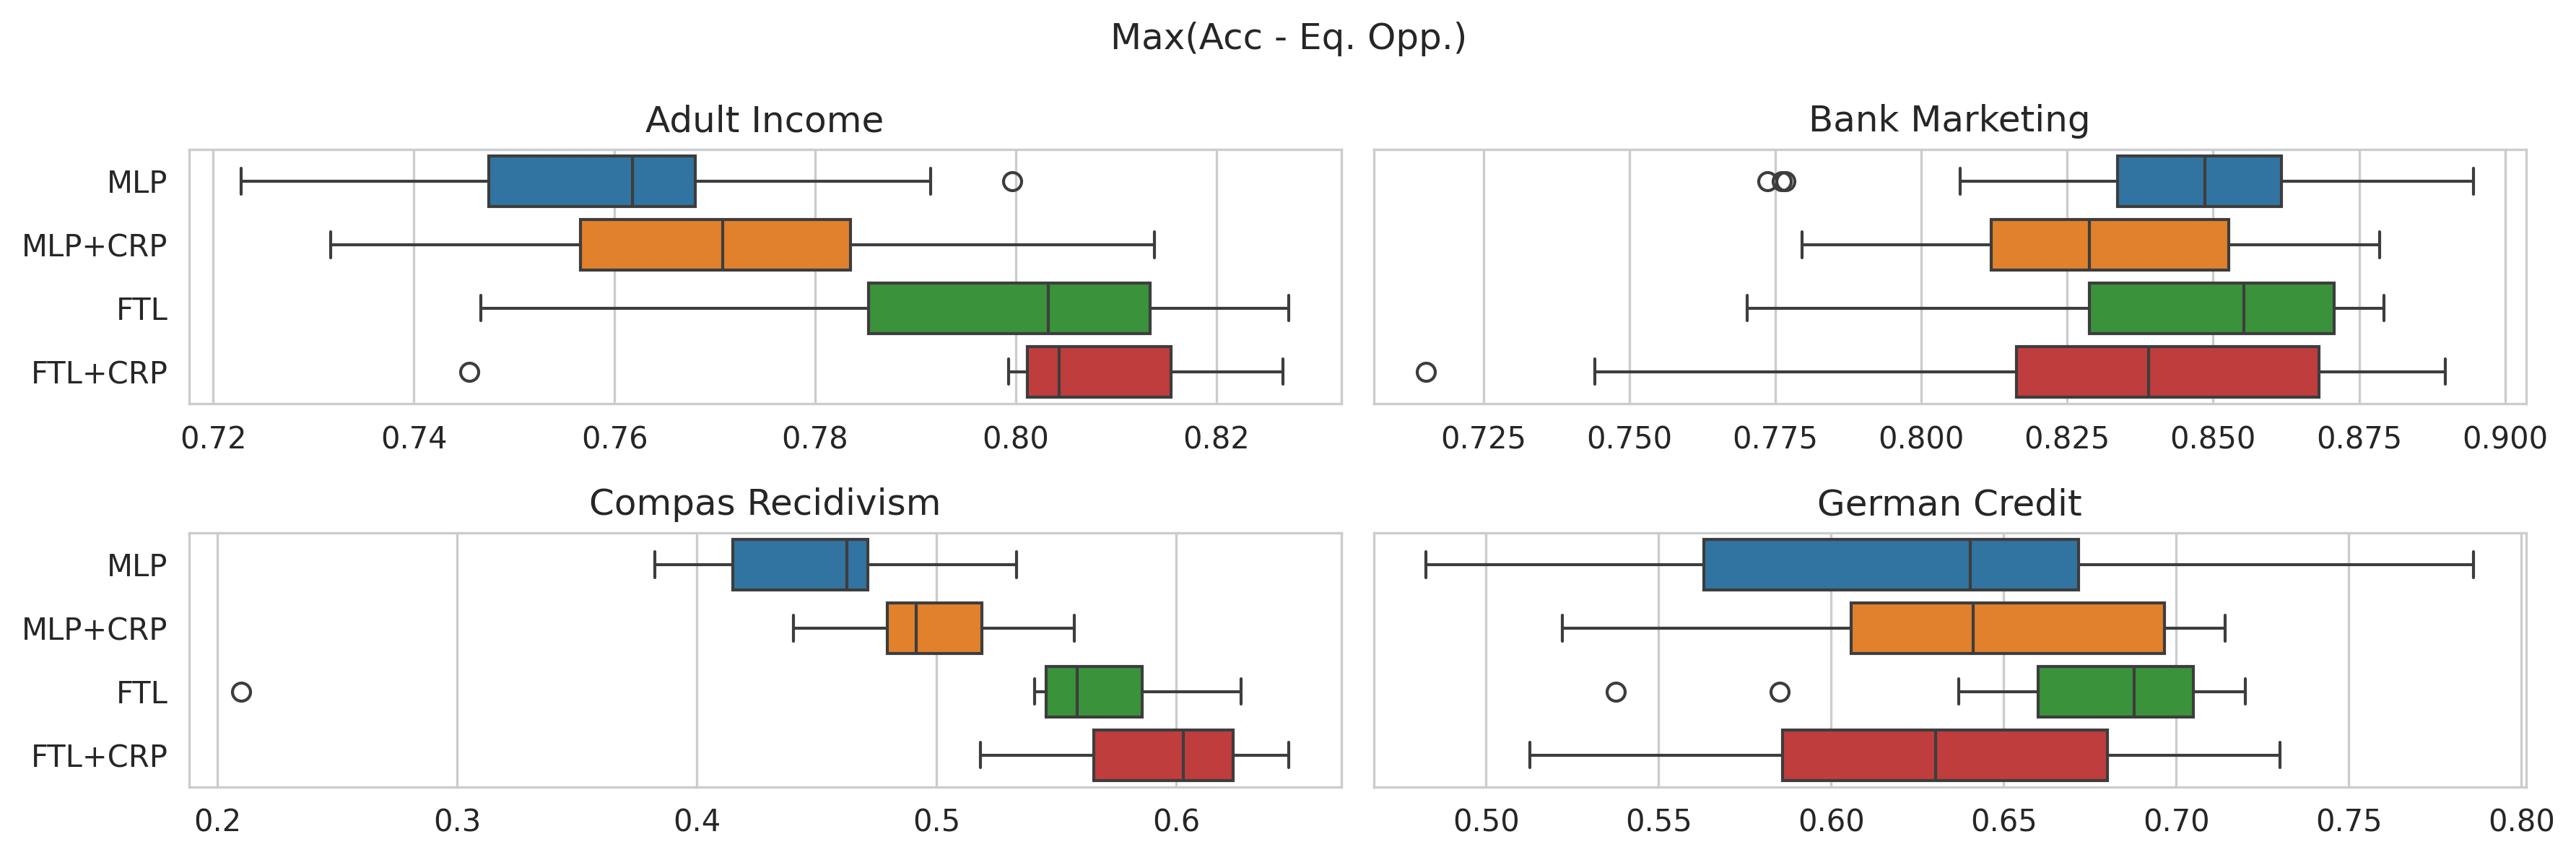

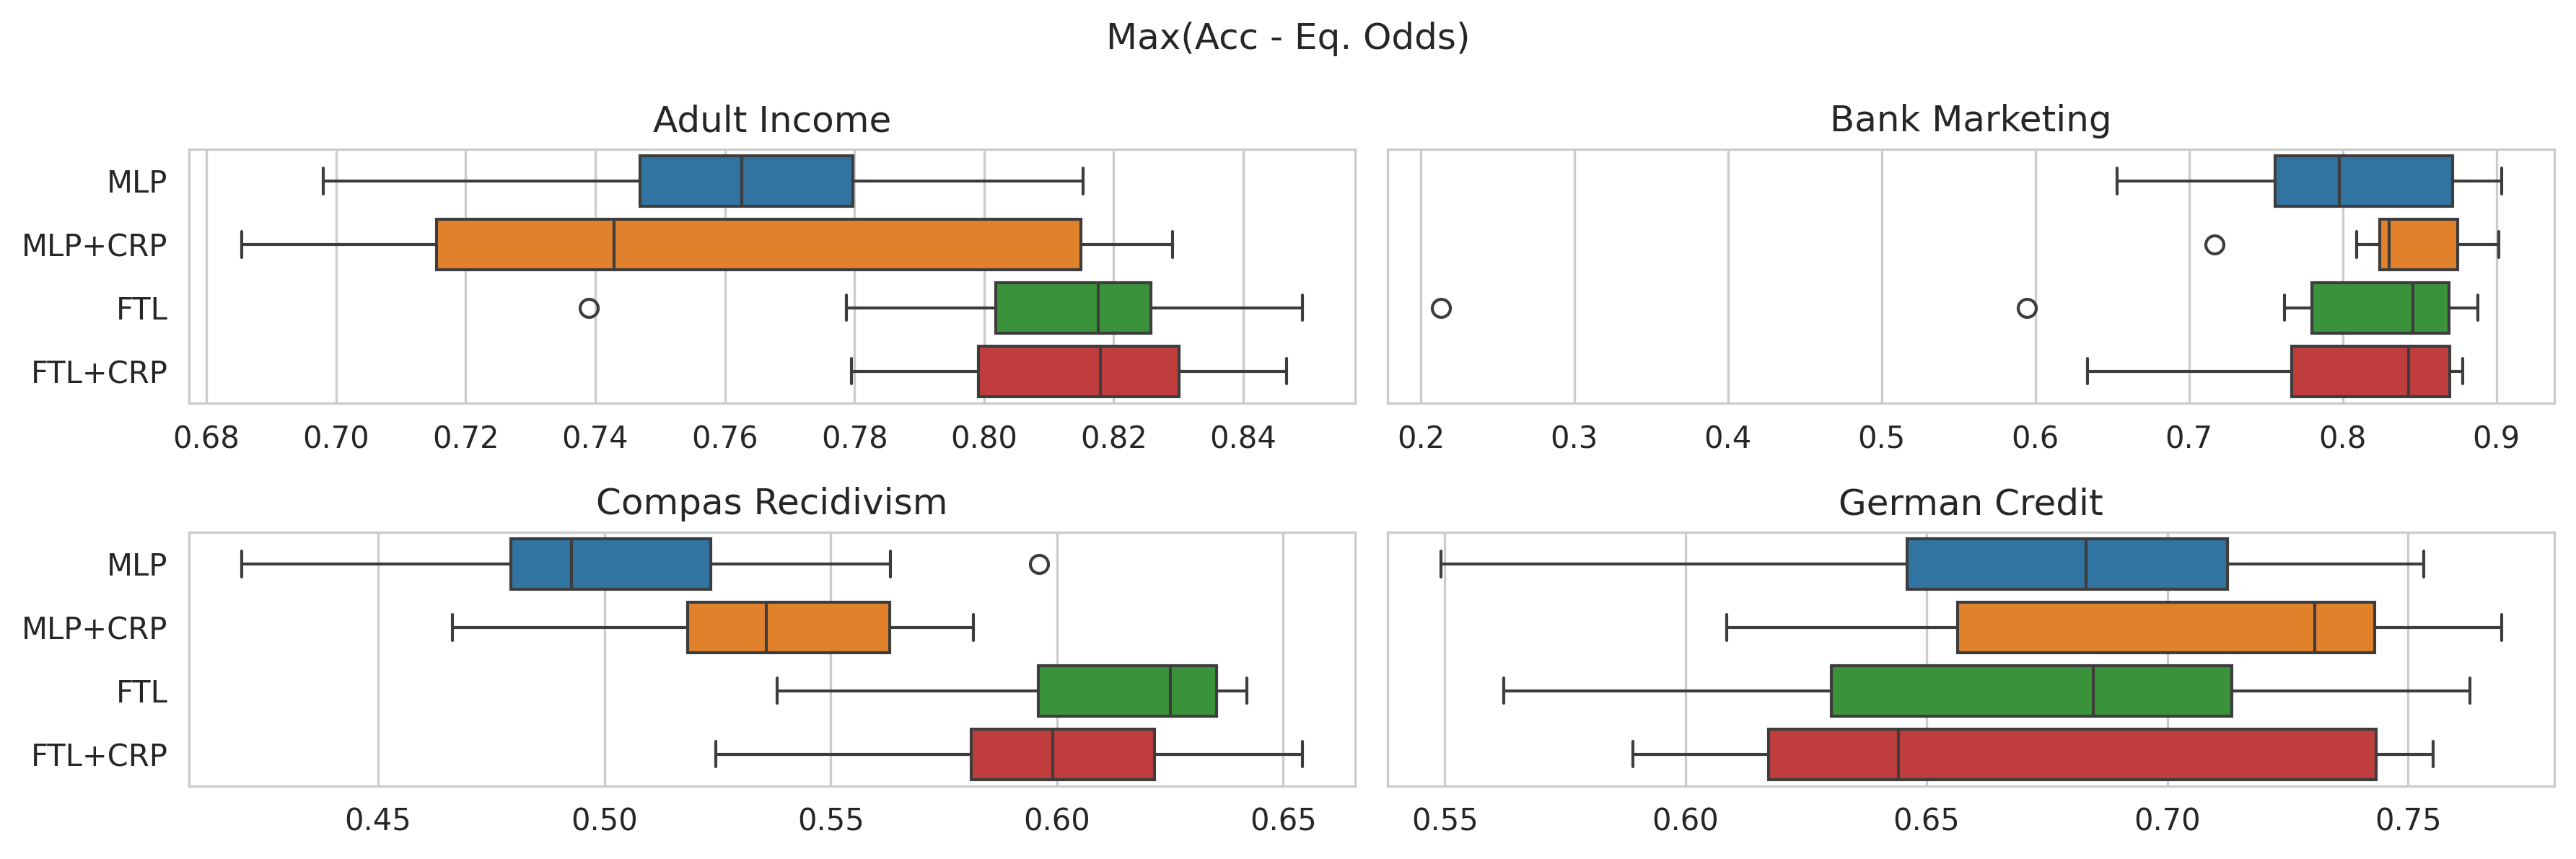

In [64]:
for fitness_rule in fitness_rules:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
    fig.subplots_adjust(hspace=0.7)
    fig.suptitle(fitness_rules_abvr[fitness_rule])

    for dataset, ax in zip(sorted(datasets), axes.flatten()):
        by_fitness_rule = results[results.fitness_rule == fitness_rule]
        by_fitness_rule = by_fitness_rule[by_fitness_rule.dataset == dataset]
        by_fitness_rule['method'] = pd.Categorical(by_fitness_rule['method'], categories=methods)
        by_fitness_rule = by_fitness_rule.sort_values(by='method')

        boxplot = sns.boxplot(data=by_fitness_rule, hue='method',
                    x='fitness', y='method', ax=ax)

        #ax.set_ylabel(dataset)
        #ax.yaxis.set_label_position("right")
        ax.set_title(dataset)
        ax.set_ylabel('')
        ax.set_xlabel('')

        ## Remove y-ticks from the second column
        if ax.get_subplotspec().colspan.start != 0:
            ax.set_yticks([])


        ## Remove x-ticks and labels from all but the last row
        if ax.get_subplotspec().rowspan.start != 3:
            ax.set_xlabel('')


    # Set x-labels for the last row
    #axes[-1].set_xlabel('Fitness')

    plt.tight_layout()
    plt.savefig('plots/boxplot_%s_crp.pdf' % fitness_rule)
    plt.savefig('plots/boxplot_%s_crp.png' % fitness_rule)
    plt.show()